<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Lab: Implementing Diffusion Models**


Estimated time needed: **45** minutes


In this lab, you will learn how to implement, train, and evaluate diffusion models using Keras. 


## Learning Objectives

By the end of this lab, you will: 
- Acquire practical understanding of diffusion model architectures, data processing, model training, and performance evaluation 
- Implement, train, and evaluate diffusion models using Keras 


----


### Prerequisites 

- Basic understanding of Python and Keras 


### Steps 

#### Step 1: Preprocess data 

Prepare the MNIST data set for training by normalizing the pixel values and reshaping the images to have a single color channel. Normalization helps in faster convergence during training, and reshaping is required because the input layer of your diffusion model expects a three-dimensional tensor. 

**1. Load and preprocess the MNIST data set:**

- Use Keras to load the MNIST data set. 
- Normalize the image pixel values to the range [0, 1]. 

**2. Reshape the Data:**
- Expand the dimensions of the images to match the input shape required by the model (28x28x1). 


In [2]:
%%capture
!pip install tensorflow-cpu==2.16.2

import os
# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [3]:
!pip install numpy

In [4]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 148.2 MB/s eta 0:00:00


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load the data set  
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values  
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)  
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Step 2: Build the diffusion model 

Build a simple diffusion model with an encoder that compresses the input image into a latent representation and a decoder that reconstructs the image from this representation. The model is compiled with the Adam optimizer and binary cross-entropy loss. 

**1. Define the encoder:**
- Create an input layer with the shape (28, 28, 1). 
- Add two Conv2D layers with increasing filter sizes and ReLU activation. 

**2. Define the bottleneck:**
- Add a flattened layer followed by a dense layer with ReLU activation. 

**3. Define the decoder:**
- Add a Dense layer to expand the bottleneck representation.  
- Reshape the output to match the original image dimensions.  
- Add two Conv2DTranspose layers with decreasing filter sizes and ReLU activation.
  
**4. Compile the model:**
- Use the Adam optimizer and binary cross-entropy loss. 


In [6]:
# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)  # Reduced filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x)  # Reduced size
x = Dense(28*28*32, activation='relu')(x)  # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')  # Using MSE for regression tasks

# Summary of the optimized model
diffusion_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

#### Step 3: Add noise to the data 

Add random noise to the data set to simulate the diffusion process: 
- Add Gaussian noise to the training and test data sets.  
- Clip the values to ensure they remain within the valid range [0, 1].  


In [7]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size


#### Step 4: Train the diffusion model 

Train the diffusion model to denoise the MINIST images. Use the noisy images as input and the original images as the target, learning to reverse the noise addition process. 
- Use the ‘fit’ method to train the model on the noisy training data. 
- Set the number of epochs to 50 and the batch size to 128. 


In [8]:
# Implement early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=2,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 477s 506ms/step - loss: 0.0334 - val_loss: 0.0160
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 477s 509ms/step - loss: 0.0130 - val_loss: 0.0133


#### Step 5: Evaluate the diffusion model 

Evaluate the performance of the trained diffusion model by predicting the denoised images and visualizing the results. Comparing the original, noisy, and denoised images will help you understand how well the model has learned to remove noise from the images. 

**1. Reconstruct images:**
- Use the diffusion model to predict the denoised test images.  
- Compare the original, noisy, and denoised images. 

**2. Visualize the results:**
- Plot a few examples of original, noisy, and denoised images side by side. 


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step


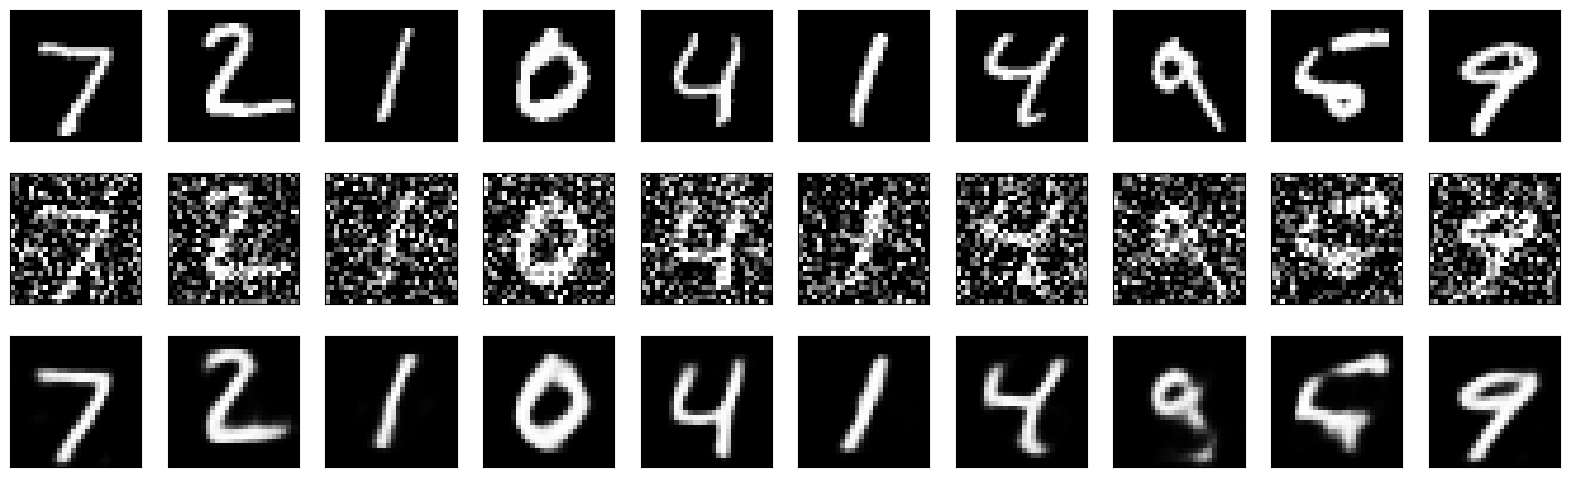

In [9]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Step 6: Fine-tune the diffusion model 

Fine-tune the diffusion model by unfreezing some layers and retraining the model to improve its performance. 


**1. Freeze the model layers:**
- Freeze all the layers of the encoder.

**2. Check the Status:** 
- Checking the trainable status of each layer.

**3. Unfreeze the model layers:** 
- Unfreeze the last few layers of the model to allow them to be retrained. 

**4. Compile and train the model:** 
- Recompile the model. 
- Train the model again for an additional 10 epochs. 


In [10]:
# Freeze all the layers 
for layer in diffusion_model.layers:
    layer.trainable = False

In [11]:
# Check trainable status of each layer
for i, layer in enumerate(diffusion_model.layers):
    print(f"Layer {i}: {layer.name} — Trainable: {layer.trainable}")

Layer 0: input_layer — Trainable: False
Layer 1: conv2d — Trainable: False
Layer 2: conv2d_1 — Trainable: False
Layer 3: flatten — Trainable: False
Layer 4: dense — Trainable: False
Layer 5: dense_1 — Trainable: False
Layer 6: reshape — Trainable: False
Layer 7: conv2d_transpose — Trainable: False
Layer 8: conv2d_transpose_1 — Trainable: False
Layer 9: conv2d_2 — Trainable: False


In [12]:
# Unfreeze the top layers of the model
for layer in diffusion_model.layers[-4:]:
    layer.trainable = True

# Compile the model again
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model again
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=2,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))


Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 299s 318ms/step - loss: 0.0963 - val_loss: 0.0974
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 298s 317ms/step - loss: 0.0954 - val_loss: 0.0969


# Exercises

### Exercise 1: Modify the noise factor  

#### Objective: 
- Change the noise factor and see how it affects the model’s ability to denoise images.
#### Instructions:  
1. Change the noise factor to 0.3.  
2. Add noise to the training and test data sets with the new noise factor.  
3. Retrain the model with the new noisy data.


In [13]:
# Write your code here
# Modify the noise factor to 0.3  
noise_factor = 0.3
# Add noise to the data with the new noise factor  
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]  
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Retrain the model  
diffusion_model.fit(x_train_noisy, x_train, epochs=2, batch_size=128,shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 268s 572ms/step - loss: 0.0855 - val_loss: 0.0848
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 270s 576ms/step - loss: 0.0851 - val_loss: 0.0845


<details>
    <summary>Click here for Solution</summary>

```python
# Modify the noise factor to 0.3  
noise_factor = 0.3  
   
# Add noise to the data with the new noise factor  
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)  
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)  
  
# Clip the values to be within the range [0, 1]  
x_train_noisy = np.clip(x_train_noisy, 0., 1.)  
x_test_noisy = np.clip(x_test_noisy, 0., 1.)  
   
# Retrain the model  
diffusion_model.fit(x_train_noisy, x_train,    
                    epochs=50,    
                    batch_size=128,    
                    shuffle=True,    
                    validation_data=(x_test_noisy, x_test))  
```

</details>


### Exercise 2 - Add more layers to the model  

#### Objective: 
- Experiment with adding more layers to the model to see how it affects performance.

#### Instructions:
1. Add an additional Conv2D layer with 128 filters in the encoder.  
2. Add an additional Conv2DTranspose layer with 128 filters in the decoder.  
3. Rebuild, compile, and train the model.


In [ ]:
# Write your code here
# Define the modified diffusion model architecture with additional layers
input_layer = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(28*28*64, activation='relu')(x)
x = Reshape((28, 28, 64))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

diffusion_model = Model(input_layer, output_layer)

# Compile the model  
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')
# Summary of the model  
diffusion_model.summary()
# Train the model  
diffusion_model.fit(x_train_noisy, x_train,epochs=2,batch_size=128,shuffle=True,validation_data=(x_test_noisy, x_test))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50176)          │     6,472,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,576,961 (74.68 MB)

 Trainable params: 19,576,961 (74.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 2999s 6s/step - loss: 0.1470 - val_loss: 0.0941
Epoch 2/2
443/469 ━━━━━━━━━━━━━━━━━━━━ 2:39 6s/step - loss: 0.0921 

<details>
    <summary>Click here for Solution</summary>

```python
# Define the modified diffusion model architecture with additional layers
input_layer = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(28*28*64, activation='relu')(x)
x = Reshape((28, 28, 64))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

diffusion_model = Model(input_layer, output_layer)

# Compile the model  
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')
   

# Summary of the model  
diffusion_model.summary()

# Train the model  
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=50,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))
```

</details>


### Exercise 3: Visualize the effect of noise  

#### Objective: 
- Compare the impact of different noise levels on the denoising performance of the model.

#### Instructions:  
1. Add noise with different factors (e.g., 0.1, 0.5, 0.7) to the test data.  
2. Use the model to predict the denoised images for each noise level.  
3. Visualize the original, noisy, and denoised images side by side for each noise level.


In [ ]:
# Write your code here
import matplotlib.pyplot as plt
   

# Function to add noise and predict denoised images
def add_noise_and_predict(noise_factor):
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    denoised_images = diffusion_model.predict(x_test_noisy)
    return x_test_noisy, denoised_images

# Noise levels to test
noise_levels = [0.1, 0.5, 0.7]
   
# Visualize the results
n = 5  # Number of digits to display
plt.figure(figsize=(20, 12))
for idx, noise_factor in enumerate(noise_levels):
    x_test_noisy, denoised_images = add_noise_and_predict(noise_factor)
    
    for i in range(n):
        # Display original
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + idx * 3 * n)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  

        if i == 0:
            ax.set_title(f'Original (Noise: {noise_factor})')
          
        # Display noisy
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + n + idx * 3 * n)
        plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  


        # Display denoised
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + 2 * n + idx * 3 * n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
plt.show()

<details>
    <summary>Click here for Solution</summary>

```python
import matplotlib.pyplot as plt
   

# Function to add noise and predict denoised images
def add_noise_and_predict(noise_factor):
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    denoised_images = diffusion_model.predict(x_test_noisy)
    return x_test_noisy, denoised_images

# Noise levels to test
noise_levels = [0.1, 0.5, 0.7]
   
# Visualize the results
n = 5  # Number of digits to display
plt.figure(figsize=(20, 12))
for idx, noise_factor in enumerate(noise_levels):
    x_test_noisy, denoised_images = add_noise_and_predict(noise_factor)
    
    for i in range(n):
        # Display original
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + idx * 3 * n)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  

        if i == 0:
            ax.set_title(f'Original (Noise: {noise_factor})')
          
        # Display noisy
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + n + idx * 3 * n)
        plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  


        # Display denoised
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + 2 * n + idx * 3 * n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
plt.show()
```

</details>


### Summary  

By completing these exercises, students will:  
1. Understand the impact of different noise factors on the model’s denoising capabilities.
2. Learn how adding more layers to the model affects its performance.
3. Visualize how different levels of noise affect the denoising results of the model. 


### Conclusion 

Congratulations! You have gained practical experience in implementing diffusion models using Keras. You learned how to preprocess data, construct a basic diffusion model architecture, add noise to the data set, train the model, and evaluate its performance. Additionally, you explored fine-tuning techniques to enhance the model’s performance. 


Copyright © IBM Corporation. All rights reserved.
